<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_processing_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystac_client
!pip install rasterio
# !pip install rio_cogeo
from pystac_client import Client as stac_client
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import dask
from dask.distributed import Client
import xarray as xr
import numpy as np

from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

import rasterio
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.vrt import WarpedVRT


from cv2 import dilate
from shapely import bounds
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# from rio_cogeo import cogeo
from google.colab import drive
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime

import glob
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 84.2 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Functions

In [3]:
def intersects(item_bbox, poly):
    return shapely.box(*item_bbox).intersects(poly)


def scale_to_reflectance(dn):
    return dn.astype('float32') * 1e-4


def scale_to_8bit(dn):
    return (((dn + 1) / 2) * 255).astype('int8')


def normalized_difference(x, y):
    denominator = x + y
    normalized_diff = (x - y) / np.where(denominator != 0, denominator, np.nan)

    return normalized_diff

In [7]:
mode = 'extra_gages'

Import vector assets

In [10]:

if mode == 'all':
    square_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/squares_15x_20250903.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/pills_3L_3W_20250903.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/all_sites/buffs_3x_width_20250903.shp')

elif mode == 'gage':
    square_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_squares_15x_20250918.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_pills_3L_3W_20250918.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp')
    pt_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_20250918.shp')

elif mode == 'extra_gages':
    square_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_squares_15x_extra.shp')
    pill_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_pills_3L_3W_extra.shp')
    circle_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp')
    pt_path =('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_points_extra.shp')



centerline_path = ('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp')


def _init_worker(square_path, pill_path, circle_path, centerline_path, href_dict_in):
    global squares, pills, circles, vector_centerline, HREFS

    squares = gpd.read_file(square_path).set_index('iindex', drop=False).set_crs(4326)
    pills = gpd.read_file(pill_path).set_index('iindex', drop=False).set_crs(4326)
    circles = gpd.read_file(circle_path).set_index('iindex', drop=False).set_crs(4326)
    vector_centerline = gpd.read_file(centerline_path).set_crs(4326)

    HREFS = href_dict_in

Generate list of images for specified date range over study area

Pair images with buffer iindices

Write to csv for easy future access without redoing stac search

In [16]:
squares = gpd.read_file(square_path).set_index('iindex', drop=False).set_crs(4326)
pts = gpd.read_file(pt_path).set_index('iindex', drop=False).set_crs(4326)

stac = stac_client.open('https://earth-search.aws.element84.com/v1')
if mode == 'all':
    search = stac.search(
        collections=['sentinel-2-l2a'],
        bbox = squares.total_bounds.tolist(),
        # datetime='2018-01-01/2024-12-31',
        datetime='2024-12-15/2024-12-20',
        query={'eo:cloud_cover': {'lt':20}},
        fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
    )

    items = list(search.items())


    work = []
    for item in tqdm(items):
        ibox = item.bbox
        for idx, row in squares.iterrows():
            if intersects(ibox, row.geometry):
                work.append((item, idx))


    files_w_ids = pd.DataFrame(work)

    files_w_ids.to_csv('/content/drive/MyDrive/stac_ids_iidx_clouds_lt20.csv')

elif mode == 'gage' or mode == 'extra_gages':

    gage_search = stac.search(
        collections=['sentinel-2-l2a'],
        bbox=squares.total_bounds.tolist(),
        datetime='2018-01-01/2024-12-31',
        query={'eo:cloud_cover': {'lt': 20}},
        fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
    )
    items = list(gage_search.items())

    work = []
    for item in items:
        ibox = item.bbox
        b3_href = item.assets['green'].href
        b8_href = item.assets['nir'].href
        scl_href = item.assets['scl'].href

        for idx, row in pts.iterrows():
            if intersects(ibox, row.geometry):
                work.append((item, idx, b3_href, b8_href, scl_href))

    id_hrefs = pd.DataFrame(work, columns=['img', 'iindex', 'b3_href', 'b8_href', 'scl_href'])

    id_hrefs['img_id'] = id_hrefs.apply(lambda x: str(x['img']).split('=')[1][0:24], axis=1)
    id_hrefs['mgrs'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[1], axis=1)
    id_hrefs['date'] = id_hrefs.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
    id_hrefs['version'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[3], axis=1)

    # find duplicate images with different processing levels

    tile_dts = []
    tile_dt_versions = []
    for row in tqdm(id_hrefs.iterrows()):
        tile = row[1]['mgrs']
        dt = row[1]['date']
        version = row[1]['version']
        tile_dts.append((tile, dt))
        tile_dt_versions.append((tile, dt, version))


    tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version'])\
        .sort_values('date')
    nonduplicates = []

    for combo in tqdm(set(tile_dts)):
        temp_mgrs = combo[0]
        temp_dt = combo[1]
        temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
            .sort_values('version', ascending=False)\
            .reset_index()

        df_out = temp_df.head(1)
        nonduplicates.append(df_out)

    nonduplicates = pd.concat(nonduplicates)



    nonduplicate_id_hrefs = pd.merge(id_hrefs, nonduplicates[['mgrs', 'date', 'version']], how='right', on=['mgrs', 'date', 'version'])
    nonduplicate_id_hrefs['year'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].year, axis=1)
    nonduplicate_id_hrefs['month'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].month, axis=1)

    nonduplicate_id_hrefs = nonduplicate_id_hrefs.set_index(['img_id', 'iindex'])
    # # href_dict = dict(zip(nonduplicate_id_hrefs['img_id'], zip(nonduplicate_id_hrefs['b3_href'], nonduplicate_id_hrefs['b8_href'], nonduplicate_id_hrefs['scl_href'])))
    nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_extra.csv')

4078it [00:00, 21701.43it/s]
100%|██████████| 2397/2397 [00:04<00:00, 525.17it/s]


Read image ids and buffer ids from csv

In [18]:
if mode == 'gage':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_20250921.csv').set_index(['img_id', 'iindex'])
elif mode == 'all':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/nonduplicate_stac_ids.csv')
elif mode == 'extra_gages':
    nonduplicate_id_hrefs = pd.read_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_extra.csv').set_index(['img_id', 'iindex'])
nonduplicate_id_hrefs

img  \
img_id                   iindex                                       
S2A_14TML_20211022_0_L2A 244511  <Item id=S2A_14TML_20211022_0_L2A>   
                         245153  <Item id=S2A_14TML_20211022_0_L2A>   
S2B_14TNL_20180923_1_L2A 259030  <Item id=S2B_14TNL_20180923_1_L2A>   
S2A_14TNL_20230412_0_L2A 259030  <Item id=S2A_14TNL_20230412_0_L2A>   
S2B_14TNL_20210127_0_L2A 259030  <Item id=S2B_14TNL_20210127_0_L2A>   
...                                                             ...   
S2B_14TML_20230818_0_L2A 244511  <Item id=S2B_14TML_20230818_0_L2A>   
                         245153  <Item id=S2B_14TML_20230818_0_L2A>   
S2B_15TTF_20191012_1_L2A 246043  <Item id=S2B_15TTF_20191012_1_L2A>   
S2B_14TNL_20220402_0_L2A 259030  <Item id=S2B_14TNL_20220402_0_L2A>   
S2B_15TTF_20240218_0_L2A 246043  <Item id=S2B_15TTF_20240218_0_L2A>   

                                                                           b3_href  \
img_id                   iindex                                                      
S2A_14TML_20211022_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20180923_1_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_14TNL_20230412_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20210127_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TML_20230818_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_15TTF_20191012_1_L2A 246043  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20220402_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_15TTF_20240218_0_L2A 246043  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   

                                                                           b8_href  \
img_id                   iindex                                                      
S2A_14TML_20211022_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20180923_1_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_14TNL_20230412_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20210127_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TML_20230818_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_15TTF_20191012_1_L2A 246043  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20220402_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_15TTF_20240218_0_L2A 246043  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   

                                                                          scl_href  \
img_id                   iindex                                                      
S2A_14TML_20211022_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20180923_1_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2A_14TNL_20230412_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_14TNL_20210127_0_L2A 259030  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
...                                                                            ...   
S2B_14TML_20230818_0_L2A 244511  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
                         245153  https://sentinel-cogs.s3.us-west-2.amazonaws.c...   
S2B_15TTF_20191012_1_L2A 246043  https://s

In [ ]:
stac = stac_client.open('https://earth-search.aws.element84.com/v1')
def search_stac_by_id(id):
    search = stac.search(collections=['sentinel-2-l2a'],
                         ids=[id],
                         fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']})

    # items = list(search.items())
    return list(search.items())[0]

In [23]:

def ref_geoms(img_id, poly_idx, view_geoms, otsu_geoms, effwidth_geoms, centerline_geoms):
    b3_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b3_href
    with rasterio.open(b3_href) as src:
        img_crs = src.crs

    view_geom  = view_geoms.loc[poly_idx].geometry
    otsu_geom  = otsu_geoms.loc[poly_idx].geometry
    eff_geom   = effwidth_geoms.loc[poly_idx].geometry

    t_view  = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_otsu  = Transformer.from_crs(otsu_geoms.crs, img_crs,  always_xy=True).transform
    t_eff   = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    otsu_src = shp_transform(t_otsu, otsu_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(otsu_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, otsu_src, eff_src, lines_in_bound


def ref_geoms_from_b3href(b3_href, poly_idx, view_geoms, otsu_geoms, effwidth_geoms, centerline_geoms):
    with rasterio.open(b3_href) as src:
        img_crs = src.crs

    view_geom = view_geoms.loc[poly_idx].geometry
    otsu_geom = otsu_geoms.loc[poly_idx].geometry
    eff_geom = effwidth_geoms.loc[poly_idx].geometry

    t_view = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_otsu = Transformer.from_crs(otsu_geoms.crs, img_crs,  always_xy=True).transform
    t_eff = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    otsu_src = shp_transform(t_otsu, otsu_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(otsu_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, otsu_src, eff_src, lines_in_bound


def dn_to_reflectance(band):
    return np.float32(band) * 1e-4


def normalized_difference(b1, b2):
    denominator = b1 + b2
    numerator = b1 - b2
    return numerator / np.where(denominator != 0, denominator, np.nan)



def process_image(img_id, poly_idx, view_geom, otsu_geom):
    b3_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b3_href
    b8_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].b8_href
    scl_href = nonduplicate_id_hrefs.loc[img_id, poly_idx].scl_href


    l, b, r, t = view_geom.bounds

    # return l, b, r, t

    with rasterio.open(b3_href) as b3_src:
        wwindow = rasterio.windows.from_bounds(float(l), float(b), float(r), float(t), b3_src.transform).round_offsets().round_lengths()

        wwindow_transform = b3_src.window_transform(wwindow)

        b3v = b3_src.read(1, window=wwindow, masked=True)
        h, w = wwindow.height, wwindow.width
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=wwindow, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
            scl_src,
            crs=b3_crs,
            transform=wwindow_transform, width=w, height=h,
            resampling=Resampling.nearest
         ) as vrt:
        sclv = vrt.read(1)
                        # , window=rasterio.windows.from_bounds(l, b, r, t, transform=scl_src.transform).round_offsets().round_lengths(), out_shape=(1, h, w), resampling=Resampling.nearest)

    sclv = np.ma.MaskedArray(sclv, mask=np.zeros_like(sclv, dtype=bool))
    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)

    ndwi_v = normalized_difference(b3v, b8v)

    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=wwindow_transform, invert=True)

    # return ndwi_v, otsu_geom_mask, wwindow_transform
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform
    else:
        return np.array([1]), None, None, None, None, None


def process_image_from_hrefs(b3_href, b8_href, scl_href, view_geom, otsu_geom):
    l, b, r, t = map(float, view_geom.bounds)

    with rasterio.open(b3_href) as b3_src:
        window = rasterio.windows.from_bounds(l, b, r, t, b3_src.transform).round_offsets().round_lengths()
        transform = b3_src.window_transform(window)

        h, w = window.height, window.width

        if h == 0 or w == 0:
            return np.array([1]), None, None, None, None, None

        b3v = b3_src.read(1, window=window, masked=True)
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=window, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
        scl_src, crs=b3_crs, transform=transform, width=w, height=h, resampling=Resampling.nearest
    ) as vrt:
        sclv = vrt.read(1)

    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)
    ndwi_v = normalized_difference(b3v, b8v)
    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=transform, invert=True)
    # return otsu_geom_mask, ndwi_v
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, transform
    else:
        return np.array([1]), None, None, None, None, None





def identify_river(wmask, lines, window_trans):
    h, w = wmask.shape
    wbool = wmask.filled(0) > 0
    # rbuffs = lines.copy().buffer(5)
    shapes = ((geom, 1) for geom in lines.geometry)
    river_seed = rasterize(
        shapes=shapes,
        out_shape= (h, w),
        transform=window_trans,
        fill=0,
        dtype='uint8',
        all_touched=True
    )
    structure = np.ones((3, 3), dtype=bool)
    river_mask = ndi.binary_propagation(input=river_seed * wbool, mask=wbool, structure=structure)
    return river_mask


def GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    b3_href, b8_href, scl_href = HREFS[(img_id, poly_idx)]

    square, pill, circle_geom, lines = ref_geoms_from_b3href(b3_href, poly_idx, squares, pills, circles, vector_centerlines)

    ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform = process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)
    # return process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)

    if ndwi_v.size > 1:

        rmask = identify_river(wmask, lines, wwindow_transform)

        return ndwi_v, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom
    else:
        return np.array([1]), None, None, None, None, None, None


def count_pixels(rmask, cloudmask, snowmask, ndmask, transform, circle):
    if rmask is not None:
        circle_mask = rasterize([circle], out_shape = rmask.shape, transform=transform, dtype='uint8', all_touched=True) == 1

        kernel = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]]).astype('uint8')

        ring_mask = dilate(circle_mask.astype('uint8'), kernel, iterations=1) & ~circle_mask

        r = rmask.astype(bool)
        c = cloudmask.astype(bool)
        s = snowmask.astype(bool)
        v = ndmask.astype(bool)

        n_pixels = np.count_nonzero(circle_mask)
        n_valid = np.count_nonzero(circle_mask & v)
        n_river = np.count_nonzero(circle_mask & r)
        n_cloud = np.count_nonzero(circle_mask & c)
        n_snow = np.count_nonzero(circle_mask & s)
        n_cloudriver = np.count_nonzero(circle_mask & r & c)

        n_edge = np.count_nonzero(ring_mask)
        n_edgeriver = np.count_nonzero(ring_mask & r)

        return n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloudriver, n_edge, n_edgeriver

    else:
        return -999, -999, -999, -999, -999, -999, -999, -999

In [24]:
def show_plot(img_id, poly_idx, squares, pills, circles, vector_centerlines):
    ndwi, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_poly = GENERATE_MASKS(img_id, poly_idx, squares, pills, circles, vector_centerlines)

    rm_cdict = {
            'red':   [[0.0, 0.0, 0.0],
                      [1.0, 1.0, 1.0]],
            'green': [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'blue':  [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'alpha': [[0.0, 0.0, 0.0],
                      [1.0, 0.35, 1.0]]
        }
    rm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=rm_cdict)

    cm_cdict = {
        'red':      [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'green':    [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'blue':     [[0.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0]],
        'alpha':    [[0.0, 0.0, 0.0],
                     [1.0, 0.2, 1.0]]
    }
    cm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=cm_cdict)

    if ndwi.size > 1:
        fig, ax = plt.subplots()
        show(ndwi, cmap='Greys_r', ax=ax, transform=wwindow_transform)
        show(rmask, cmap=rm_cmap, ax=ax, transform=wwindow_transform)
        show(cloudmask, cmap=cm_cmap, ax=ax, transform=wwindow_transform)
        gpd.GeoSeries([circle_poly]).plot(ax=ax, facecolor='none')

    else:
        print('not enough in window')
    # tfig = plt.Figure()
    # ax_ndwi = tfig.add_subplot(1, 2, 1)
    # show(ndwi, cmap='Greys_r', ax=ax_ndwi)
    # ax_scl = tfig.add_subplot(1, 2, 2)
    # show(ndmask, cmap='Paired', ax=ax_scl)
    # tfig.suptitle(f'{img_id}_{poly_idx}')
    # tfig.tight_layout()

    # return fig

Get effective width at all gage sites in for loop\
Will identify good images after the fact using river tinder

In [ ]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
year_imgs = {}
for y in years:
    year_imgs[y] = (nonduplicate_id_hrefs.loc[nonduplicate_id_hrefs.year == y])

href_dict = {(row.img_id, int(row.iindex)): (row.b3_href, row.b8_href, row.scl_href)
    for _, row in nonduplicate_id_hrefs.reset_index().iterrows()}


def _worker(args):
    img_id, idx = args
    # return idx
    try:
        ndwi, rmask, cloudmask, snowmask, ndmask, trans, circle_poly = GENERATE_MASKS(
            img_id, idx, squares, pills, circles, vector_centerline
        )
        if ndwi.size < 1:
            return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)

        return(img_id, idx, *count_pixels(rmask, cloudmask, snowmask, ndmask, trans, circle_poly))

    except Exception:
        return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)


paths = (square_path, pill_path, circle_path, centerline_path)

if mode == 'gage' or mode == 'extra_gages':

    with ProcessPoolExecutor(max_workers=min(4, mp.cpu_count()), initializer=_init_worker, initargs=(paths[0], paths[1], paths[2], paths[3], href_dict)) as ex:
        for y in years:
            path_out = (f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{y}_gx_20250927.csv')
            if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_*.csv')):

                tempdf = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.year == y)].copy()
                recs = tempdf.index.tolist()

                rows = list(tqdm(ex.map(_worker, recs, chunksize=8), total=len(recs), desc=str(y)))
                output = pd.DataFrame(rows, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
                output.to_csv(path_out)

else:

    work['date'] = pd.to_datetime(work['date'])
    work['year'] = work.apply(lambda x: (x['date']).year, axis=1)
    work['month'] = work.apply(lambda x: (x['date']).month, axis=1)

    for year in years:
        for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
            path_out = f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{month}_{year}.csv'

            if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/all_sites/effwidths_*.csv')):

                tempwork = work.loc[(work.year == year) & (work.month == month)].copy()

                records = list(zip(tempwork['img_id'].tolist(), tempwork['iindex'].astype(int).tolist()))

                results = []

                with ProcessPoolExecutor(max_workers=min(8, mp.cpu_count())) as ex:
                    futures = [ex.submit(_worker, r) for r in records]
                    for f in tqdm(as_completed(futures), total=len(futures), desc=f'{year}-{month}'):
                        results.append(f.result())
                # for record in tqdm(records):
                #     results.append(_worker(record))
                output = pd.DataFrame(results, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
                output.to_csv(path_out)

                completed_my.append((month, year))

2019:  39%|███▊      | 153/395 [05:30<07:18,  1.81s/it]

In [ ]:
output

,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver
0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9
1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4
2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4
3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7
4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3
5,S2A_13TGF_20180703_2_L2A,225467,162,162,69,0,0,0,43,9
6,S2A_14TPM_20180714_0_L2A,120725,164,164,44,164,0,44,43,13
7,S2A_14TPM_20180714_0_L2A,27910,1981,1981,412,157,0,45,145,20
8,S2B_13TDE_20181029_0_L2A,41178,254,254,54,0,0,0,54,3
9,S2B_13TDE_20181029_0_L2A,38194,71,71,20,71,0,20,29,6


In [38]:
paths

('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_squares_15x_extra.shp',
 '/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_pills_3L_3W_extra.shp',
 '/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_extra.shp',
 '/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp')

In [32]:
tid = 'S2B_15TTF_20240218_0_L2A'
tidx = 246043
b3_href = nonduplicate_id_hrefs.loc[tid, tidx].b3_href
b8_href = nonduplicate_id_hrefs.loc[tid, tidx].b8_href
scl_href = nonduplicate_id_hrefs.loc[tid, tidx].scl_href

square, pill, circle, lines = ref_geoms_from_b3href(b3_href, tidx, squares, pills, circles, vector_centerline)

ndwi, water, cloud, snow, ndmask, transform = process_image_from_hrefs(b3_href, b8_href, scl_href, square, pill)
river = identify_river(water, lines, transform)

In [51]:
href_dict = {(row.img_id, int(row.iindex)): (row.b3_href, row.b8_href, row.scl_href)
    for _, row in nonduplicate_id_hrefs.reset_index().iterrows()}

_init_worker(square_path, pill_path, circle_path, centerline_path, href_dict)

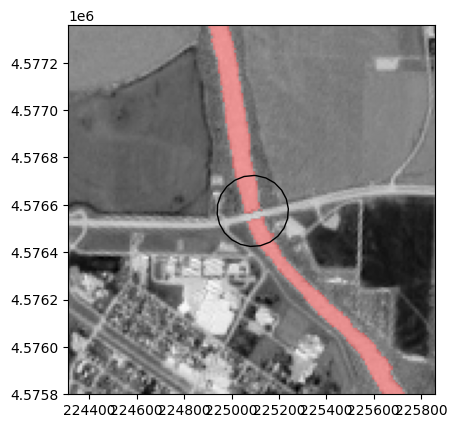

In [30]:
timg = 'S2B_15TTF_20240218_0_L2A'
tindx = 246043
show_plot(timg, tindx, squares, pills, circles, vector_centerline)

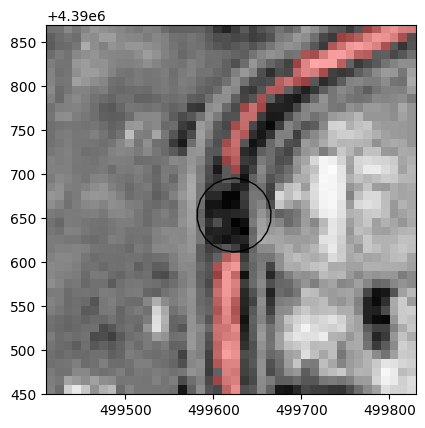

In [ ]:
timg = 'S2B_13SDD_20210406_1_L2A'
tindx = 38194
show_plot(timg, tindx, squares, pills, circles, vector_centerline)